In [1]:
#!pip install datascience
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## Alameda County Juries

In [2]:
# Data from an ACLU 2010 report
# Racial and Ethnic Disparities in Alameda County Jury Pools
# https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf

alameda = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

alameda.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


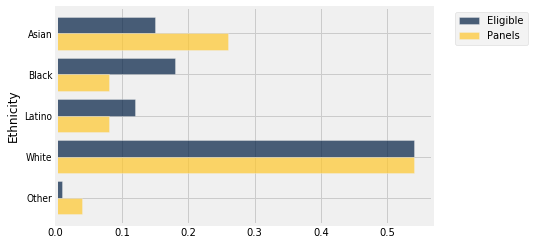

In [3]:
alameda.barh(0)

## Total Variation Distance

In [4]:
diff = alameda.with_column('Difference',
                    alameda.column('Eligible') - alameda.column('Panels'))
diff

Ethnicity,Eligible,Panels,Difference
Asian,15%,26%,-0.11
Black,18%,8%,0.1
Latino,12%,8%,0.04
White,54%,54%,0
Other,1%,4%,-0.03


In [5]:
abs_diff = diff.with_column('Abs. Difference',
                        np.abs(diff.column('Difference')))
abs_diff

Ethnicity,Eligible,Panels,Difference,Abs. Difference
Asian,15%,26%,-0.11,0.11
Black,18%,8%,0.1,0.1
Latino,12%,8%,0.04,0.04
White,54%,54%,0,0
Other,1%,4%,-0.03,0.03


In [6]:
sum(abs_diff.column('Abs. Difference')) / 2

0.14

In [7]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

In [8]:
def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

In [9]:
observed = table_tvd(alameda, 'Eligible', 'Panels')
observed

0.14

## Simulating the statistic

In [10]:
def get_one_simulated_panel(t, n):
    return t.select('Ethnicity').sample(n, weights=t.column('Eligible'))

get_one_simulated_panel(alameda, 1453)

Ethnicity
Other
Black
Black
White
Latino
White
Latino
White
White
White


In [11]:
def simulate_once(t, n):
    simulated_panel = get_one_simulated_panel(t, n)
    counts = simulated_panel.group('Ethnicity')
    sim_proportions = counts.select('Ethnicity').with_column('Random',
                                    counts.column('count') / n)
    sim_proportions.set_format(1, PercentFormatter(0))
    return t.join('Ethnicity', sim_proportions)

In [12]:
simulate_once(alameda, 1453)

Ethnicity,Eligible,Panels,Random
Asian,15%,26%,15%
Black,18%,8%,19%
Latino,12%,8%,12%
Other,1%,4%,1%
White,54%,54%,53%


In [13]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # 1000 repetitions of the simulation
    sim_results = simulate_once(alameda, 1453)
    tvds = np.append(tvds, table_tvd(sim_results, 'Eligible', 'Random'))

results = Table().with_column('TVD', tvds)
results

TVD
0.0196284
0.0336545
0.0116311
0.00958706
0.020351
0.0205781
0.0150723
0.0113833
0.0147488
0.0226979


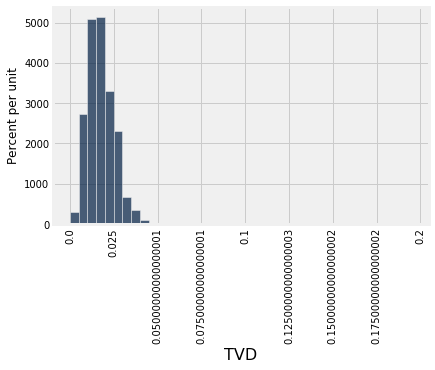

In [14]:
results.hist(bins=np.arange(0, 0.2, 0.005))

## P-value

In [15]:
results.where('TVD', are.above_or_equal_to(0.14)).num_rows / results.num_rows

0.0

## Swain v. Alabama, repeat

In [38]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


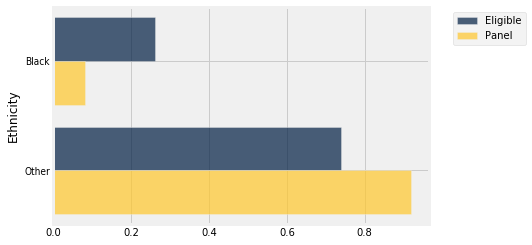

In [39]:
swain.barh(0)

In [40]:
observed = table_tvd(swain, 'Eligible', 'Panel')
observed

0.18000000000000002

In [41]:
simulate_once(swain, 100)

Ethnicity,Eligible,Panel,Random
Black,26%,8%,26%
Other,74%,92%,74%


In [42]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(10000): # 10000 repetitions of the simulation
    sim_results = simulate_once(swain, 100)
    tvds = np.append(tvds, table_tvd(sim_results, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.03
0.05
0.02
0.04
0.02
0.07
0.02
0
0.02
0


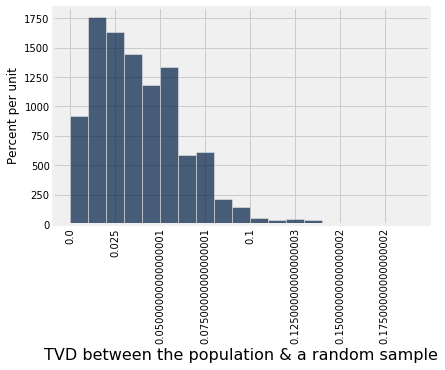

In [43]:
results.hist(bins=np.arange(0, 0.20, 0.010))

In [44]:
results.where('TVD between the population & a random sample', are.above_or_equal_to(observed)).num_rows / results.num_rows

0.0

# Birth months

What month were you born in?

* A) Jan-Mar
* B) Apr-Jun
* C) Jul-Sep
* D) Oct-Dec

In [55]:
birth_month = Table().with_columns(
    "Month", make_array("Jan-Mar", "Apr-Jun", "Jul-Sep", "Oct-Dec"),
    "Count", make_array(5,5,5,5))
birth_month

Month,Count
Jan-Mar,5
Apr-Jun,5
Jul-Sep,5
Oct-Dec,5


In [56]:
size_of_class = sum(birth_month.column("Count"))
observed = sum(abs(birth_month.column("Count")/size_of_class - .25))
observed

0.0

How likely is this distribution of birth months?

In [57]:
random_counts = birth_month.select("Month").sample(size_of_class).group("Month")
random_counts

Month,count
Apr-Jun,2
Jan-Mar,5
Jul-Sep,8
Oct-Dec,5


In [58]:
tvds = make_array()
for i in np.arange(10000): # 10000 repetitions
    random_counts = birth_month.select("Month").sample(size_of_class).group("Month").column("count")
    tvd = sum(abs(random_counts/sum(random_counts) - .25))
    tvds = np.append(tvds, tvd)
    
results = Table().with_column('TVD', tvds)

In [59]:
results

TVD
0.2
0.6
0.2
0.3
0.1
0.3
0.3
0.1
0.2
0.3


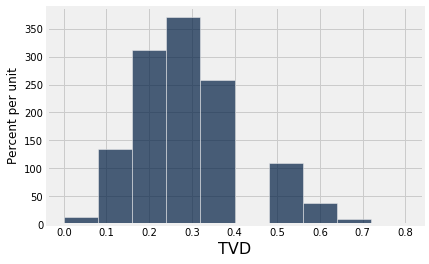

In [60]:
results.hist()

In [52]:
results.where('TVD', are.above_or_equal_to(observed)).num_rows / 10000

1.0